# Course Information
DDS8555 - Predictive Analysis<br>
Assignment 5<br>
COmpute in Multi-Class Prediction of Obesity Risk kaggle competition.

By - Samuel Mbah Nde
Due Date and Time: Sunday February 23rd 2025 at 11:59PM PST.

## Import the packages needed to load and analyze the data set
I will load all the packages needed in one place to keep my code organized.

In [114]:
import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from scipy.stats import probplot
import re, os, json, requests, random
from datetime import datetime, timedelta, timezone
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet, ElasticNetCV, LassoCV
from sklearn.discriminant_analysis import  LinearDiscriminantAnalysis as LDA,       QuadraticDiscriminantAnalysis as QDA, LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.svm import SVC, SVR
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV, KFold
from sklearn.metrics import (mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, f1_score,
                            precision_score, recall_score, accuracy_score,
                            confusion_matrix, ConfusionMatrixDisplay, classification_report)


from sklearn.discriminant_analysis import  LinearDiscriminantAnalysis as LDA,  QuadraticDiscriminantAnalysis as QDA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB

from sklearn.pipeline import Pipeline
from sklearn import datasets

## Set seed to ensure work is reproducible.

In [5]:
random.seed(6222)

## Load the data into pandas dataframes

In [175]:
path_to_data_files = 'Data/ObesityRisk'
train = pd.read_csv(f"{path_to_data_files}/train.csv")
test = pd.read_csv(f"{path_to_data_files}/test.csv")
sample_submission = pd.read_csv(f"{path_to_data_files}/sample_submission.csv")
test_ids = test['id']

train.shape, test.shape, sample_submission.shape 

((20758, 18), (13840, 17), (13840, 2))

In [118]:
sample_submission.head()

,id,NObeyesdad
0,20758,Normal_Weight
1,20759,Normal_Weight
2,20760,Normal_Weight
3,20761,Normal_Weight
4,20762,Normal_Weight


## EDA

In this section, I will 
1) Inpect the datasets.
2) Check for the presense of NAs.
3) Rename columns to make it easier to explore using column dot notation.
4) Visuallize the data.

In [10]:
train.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


## Check for the Presense of NAs
The dataset documention indicates that there should be no nulls in the dataset.

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  int64  
 1   Gender                          20758 non-null  object 
 2   Age                             20758 non-null  float64
 3   Height                          20758 non-null  float64
 4   Weight                          20758 non-null  float64
 5   family_history_with_overweight  20758 non-null  object 
 6   FAVC                            20758 non-null  object 
 7   FCVC                            20758 non-null  float64
 8   NCP                             20758 non-null  float64
 9   CAEC                            20758 non-null  object 
 10  SMOKE                           20758 non-null  object 
 11  CH2O                            20758 non-null  float64
 12  SCC                             

In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13840 entries, 0 to 13839
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              13840 non-null  int64  
 1   Gender                          13840 non-null  object 
 2   Age                             13840 non-null  float64
 3   Height                          13840 non-null  float64
 4   Weight                          13840 non-null  float64
 5   family_history_with_overweight  13840 non-null  object 
 6   FAVC                            13840 non-null  object 
 7   FCVC                            13840 non-null  float64
 8   NCP                             13840 non-null  float64
 9   CAEC                            13840 non-null  object 
 10  SMOKE                           13840 non-null  object 
 11  CH2O                            13840 non-null  float64
 12  SCC                             

## Create a summary table of metrics to compare.
Below, I compute summary statistics on train and test sets and merge them to compare. This approach will help with quickly spotting any columns that are unevenly distributed in the test and training sets.

In [15]:
train.drop(['id'], axis = 1).describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000
mean,23.841804,1.700245,87.887768,2.445908,2.761332,2.029418,0.981747,0.616756
std,5.688072,0.087312,26.379443,0.533218,0.705375,0.608467,0.838302,0.602113
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,20.000000,1.631856,66.000000,2.000000,3.000000,1.792022,0.008013,0.000000
50%,22.815416,1.700000,84.064875,2.393837,3.000000,2.000000,1.000000,0.573887
75%,26.000000,1.762887,111.600553,3.000000,3.000000,2.549617,1.587406,1.000000
max,61.000000,1.975663,165.057269,3.000000,4.000000,3.000000,3.000000,2.000000


In [16]:
numerical_cols = train.select_dtypes(include=['float64']).columns.tolist()
numerical_cols

['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

In [17]:
def round_values(value, dp=3):
    if type(value) in [str, int]:
        return value
    return round(value, dp)

def get_outliers_iqr(data:list):
    """Detects outliers in a list of numbers using the IQR method."""
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = []
    for num in data:
        if num < lower_bound or num > upper_bound:
            outliers.append(num)
    return outliers

def compute_summary_numbers(df):
    summary_metrics = []
    total_recs = df.shape[0]
    for column in df.columns:
        values = df[column].values.tolist()  # Corrected column access
        n_unique = len(set(values))
        number_of_nulls = df[column].isna().sum()  # Calculate nulls directly
        number_of_valid = total_recs - number_of_nulls
        data_type = str(df[column].dtype)
        mean = np.mean(values)
        std = np.std(values)
        fisher_kurtosis = stats.kurtosis(values, fisher=True)
        pearson_kurtosis = stats.kurtosis(values, fisher=False)
        skewness = stats.skew(values)
        min_value = min(values)
        max_value = max(values)
        percentile_25 = np.percentile(values, 25)
        percentile_50 = np.percentile(values, 50)
        percentile_75 = np.percentile(values, 75)
        iqr = percentile_75 - percentile_25
        lower_bound = percentile_25 - 1.5 * iqr
        upper_bound = percentile_75 + 1.5 * iqr

        outliers = [value for value in values if value > upper_bound or value < lower_bound]
        if(data_type == 'object'):
            data_type = 'str'
        outliers_percentage = 100* len(outliers)/total_recs
        completeness = round(100* number_of_nulls / total_recs, 3)  # Calculate completeness
        raw_values = [column, data_type, n_unique, mean, std, fisher_kurtosis, pearson_kurtosis, skewness,
                      min_value, percentile_25, percentile_50, percentile_75, max_value, len(outliers), outliers_percentage]
        rounded_values = [round_values(value) for value in raw_values]
        summary_metrics.append(rounded_values)
    return pd.DataFrame(summary_metrics, columns=['ColumnName', 'DataType', 'NUnique', 'Mean', 'Std', 'FisherKurtosis', 'PeasonKurtosis',
                                       'Skewness', 'Min', '25thPercentile', '50thPercentile', '75thPercentile', 'Max', 'NOutliers', 'OutliersPercent'])

# Create a DataFrame from the collected summary statistics
train_summary = compute_summary_numbers(train[numerical_cols])
test_summary = compute_summary_numbers(test[numerical_cols])
train_summary

,ColumnName,DataType,NUnique,Mean,Std,FisherKurtosis,PeasonKurtosis,Skewness,Min,25thPercentile,50thPercentile,75thPercentile,Max,NOutliers,OutliersPercent
0,Age,float64,1703,23.842,5.688,3.699,6.699,1.586,14.00,20.000,22.815,26.000,61.000,1074,5.174
1,Height,float64,1833,1.700,0.087,-0.560,2.440,0.016,1.45,1.632,1.700,1.763,1.976,4,0.019
2,Weight,float64,1979,87.888,26.379,-0.997,2.003,0.093,39.00,66.000,84.065,111.601,165.057,0,0.000
3,FCVC,float64,934,2.446,0.533,-0.893,2.107,-0.357,1.00,2.000,2.394,3.000,3.000,0,0.000
4,NCP,float64,689,2.761,0.705,1.837,4.837,-1.562,1.00,3.000,3.000,3.000,4.000,6052,29.155
5,CH2O,float64,1506,2.029,0.608,-0.744,2.256,-0.212,1.00,1.792,2.000,2.550,3.000,0,0.000
6,FAF,float64,1360,0.982,0.838,-0.495,2.505,0.506,0.00,0.008,1.000,1.587,3.000,0,0.000
7,TUE,float64,1297,0.617,0.602,-0.418,2.582,0.670,0.00,0.000,0.574,1.000,2.000,0,0.000


In [18]:
test_summary['DataSource'] = 'Test'
train_summary['DataSource'] = 'Train'

summary_stats = pd.concat(objs=[test_summary, train_summary], axis = 0)
summary_stats.sort_values(by=['ColumnName', 'DataSource'], inplace = True, ignore_index = True)
summary_stats.to_csv('SummaryOfDescriptiveStatisticsFromAbaloneDataset.csv', index = False)
summary_stats

,ColumnName,DataType,NUnique,Mean,Std,FisherKurtosis,PeasonKurtosis,Skewness,Min,25thPercentile,50thPercentile,75thPercentile,Max,NOutliers,OutliersPercent,DataSource
0,Age,float64,1539,23.953,5.800,3.539,6.539,1.572,14.00,20.000,22.906,26.000,61.000,791,5.715,Test
1,Age,float64,1703,23.842,5.688,3.699,6.699,1.586,14.00,20.000,22.815,26.000,61.000,1074,5.174,Train
2,CH2O,float64,1366,2.032,0.611,-0.757,2.243,-0.199,1.00,1.772,2.000,2.552,3.000,0,0.000,Test
3,CH2O,float64,1506,2.029,0.608,-0.744,2.256,-0.212,1.00,1.792,2.000,2.550,3.000,0,0.000,Train
4,FAF,float64,1260,0.975,0.840,-0.466,2.534,0.529,0.00,0.001,1.000,1.572,3.000,0,0.000,Test
5,FAF,float64,1360,0.982,0.838,-0.495,2.505,0.506,0.00,0.008,1.000,1.587,3.000,0,0.000,Train
6,FCVC,float64,828,2.443,0.532,-0.895,2.105,-0.343,1.00,2.000,2.358,3.000,3.000,0,0.000,Test
7,FCVC,float64,934,2.446,0.533,-0.893,2.107,-0.357,1.00,2.000,2.394,3.000,3.000,0,0.000,Train
8,Height,float64,1739,1.699,0.089,-0.538,2.462,0.064,1.45,1.632,1.700,1.761,1.980,4,0.029,Test
9,Height,float64,1833,1.700,0.087,-0.560,2.440,0.016,1.45,1.632,1.700,1.763,1.976,4,0.019,Train


In [19]:
summary_stats.to_clipboard(index = False)

## **Observations from the summary statistics comparison table**
From the table, one can see that the range of value of both train and test sets are very similar.

This gives us confidence in training model on the train set and evaluating on the test set.

In [21]:
train.NObeyesdad.value_counts()

NObeyesdad
Obesity_Type_III       4046
Obesity_Type_II        3248
Normal_Weight          3082
Obesity_Type_I         2910
Insufficient_Weight    2523
Overweight_Level_II    2522
Overweight_Level_I     2427
Name: count, dtype: int64

## Visuallising the data
I first start with a pairplot of the training set.

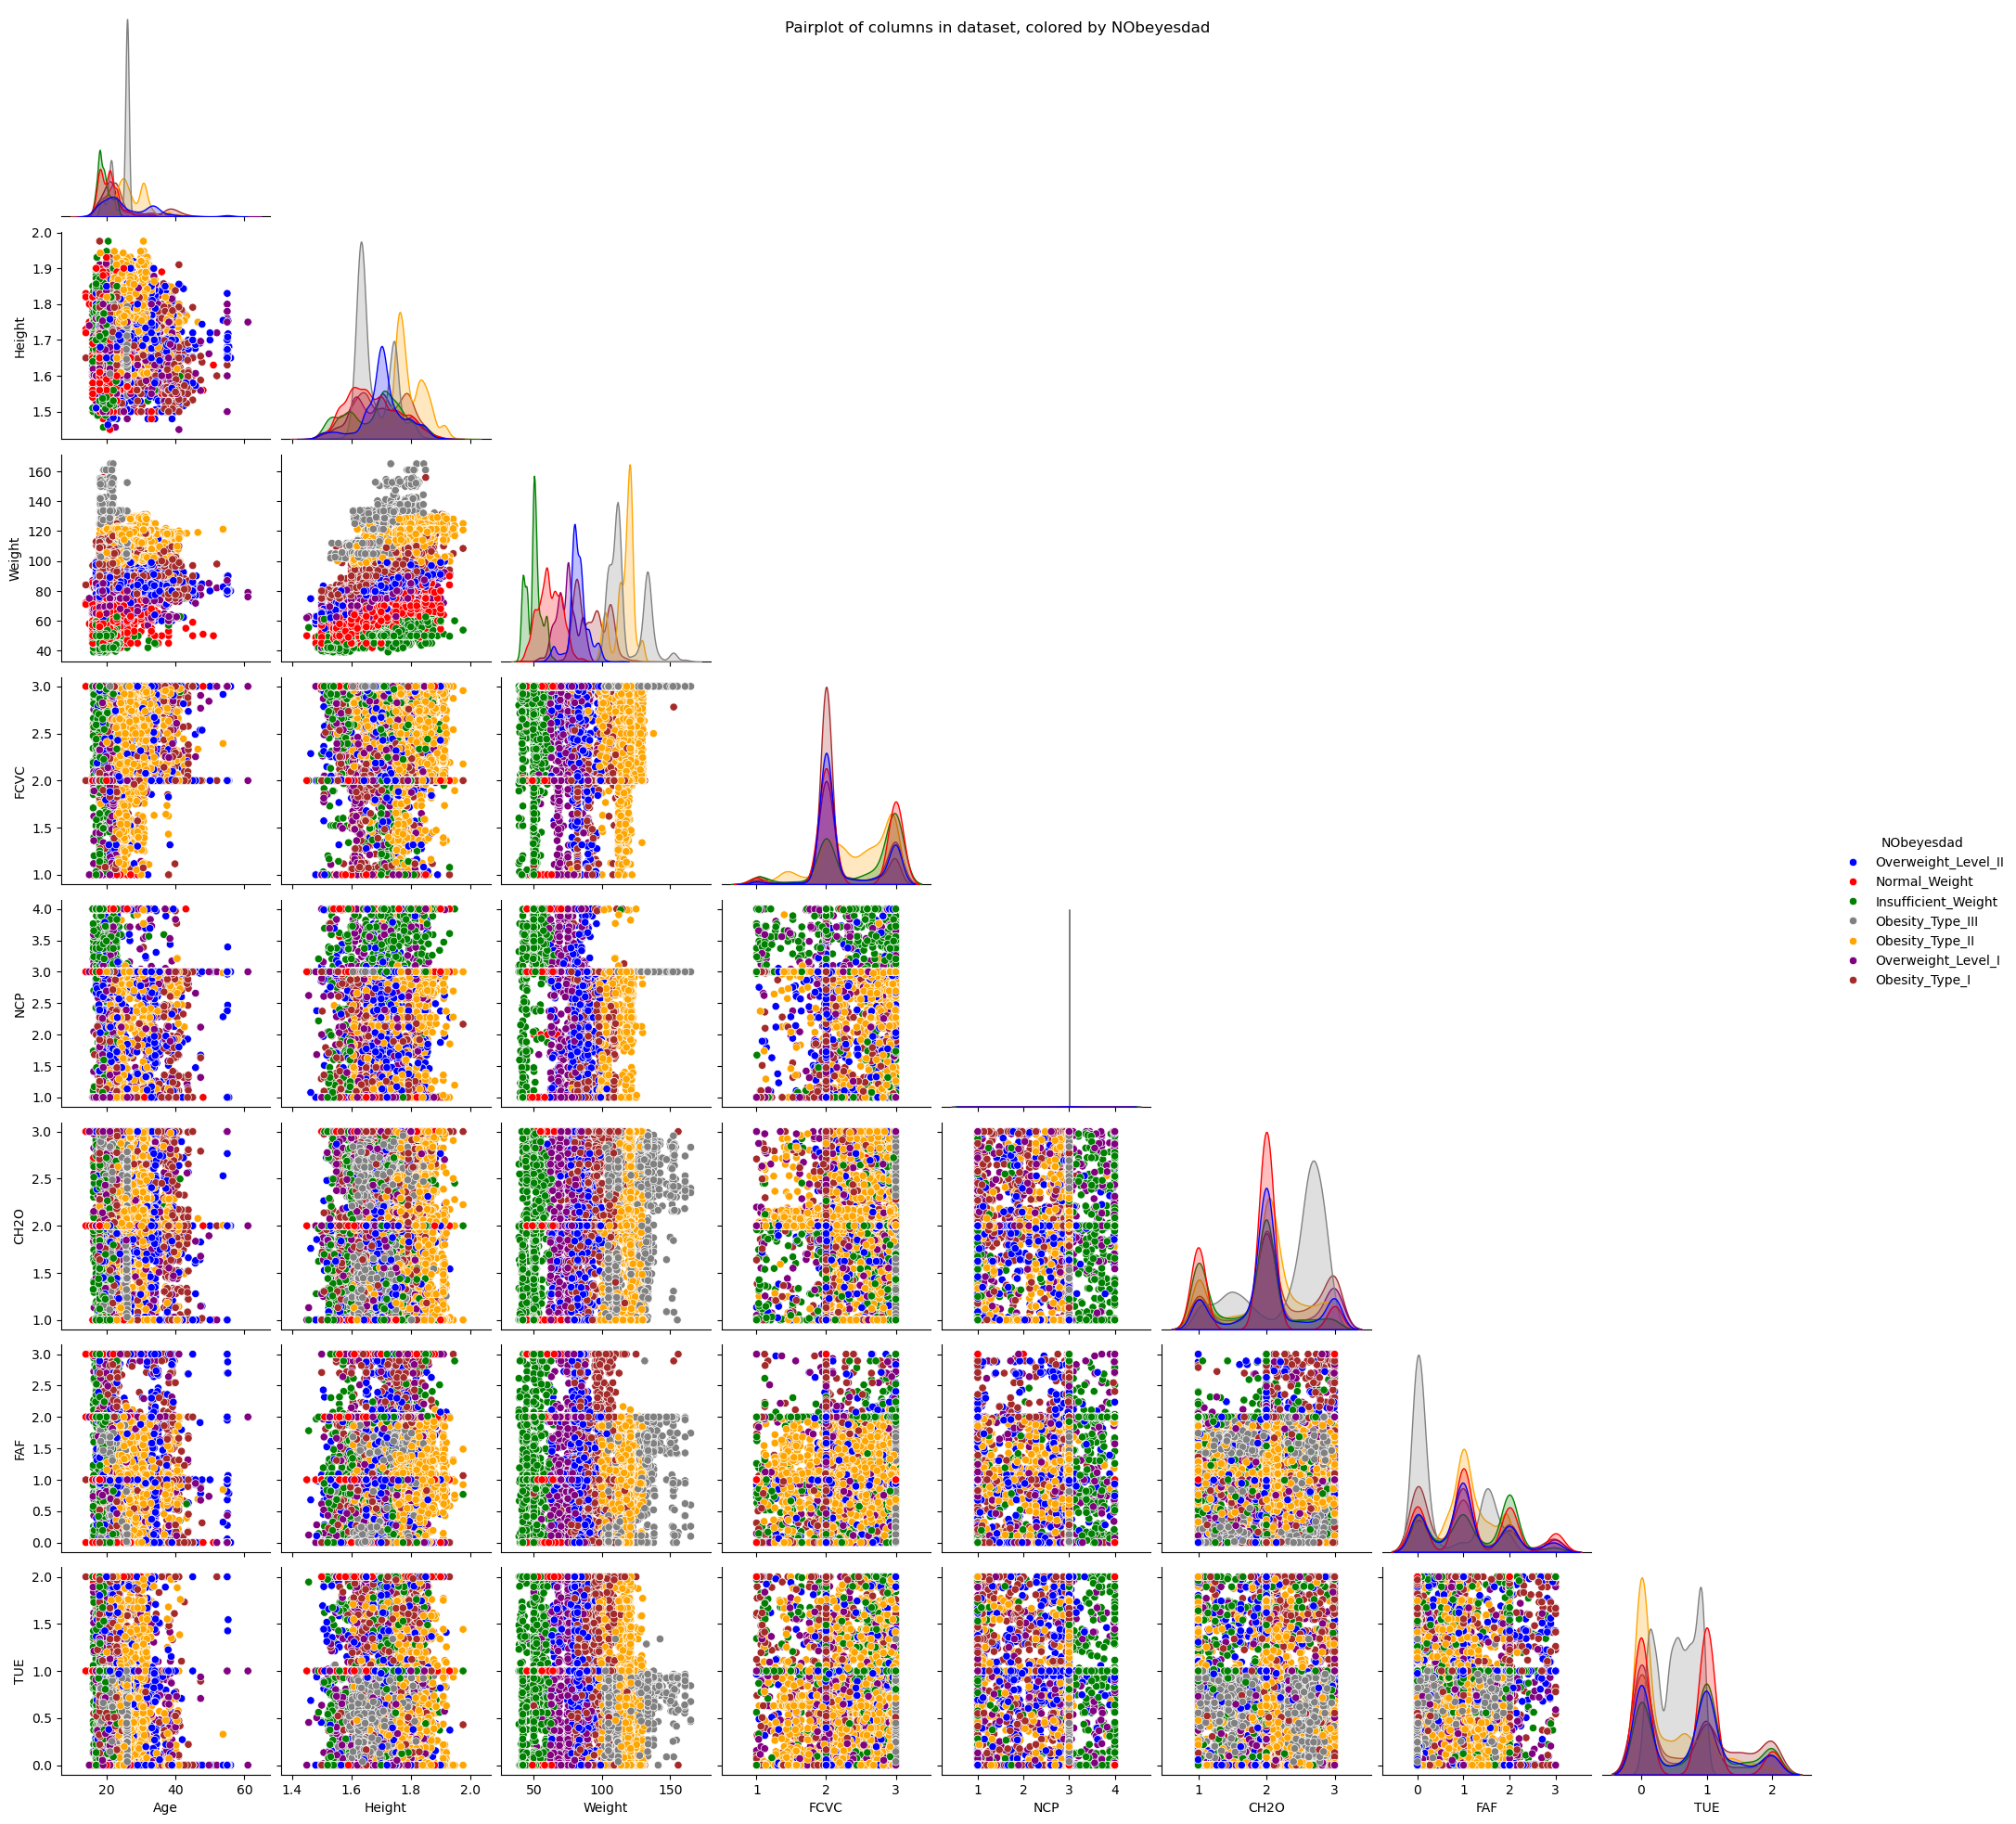

In [23]:
colors = [
    "blue",
    "red",
    "green",
    "gray",
    "orange",
    "purple",
    "brown",
    "pink",
    "cyan",
    "magenta"
]
def plot_pairplot_of_dataset(df, hue, id_column):
    print('\n\n')
    g = sns.pairplot(df.drop(id_column, axis=1), corner=True, diag_kind='kde', hue=hue, palette=colors[:train[hue].nunique()])
    # Set the title of the plot
    g.fig.suptitle(f"Pairplot of columns in dataset, colored by {hue}")
    plt.show()
plot_pairplot_of_dataset(train, 'NObeyesdad', 'id')

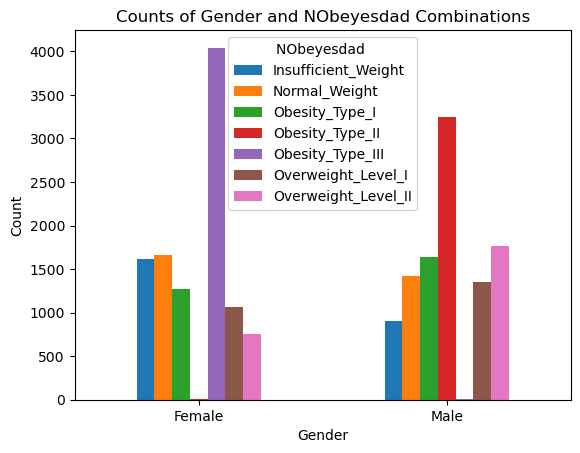

In [24]:
grouped_data = train.groupby(['Gender', 'NObeyesdad']).size().unstack()

# Plotting the bar chart
grouped_data.plot(kind='bar', rot=0)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Counts of Gender and NObeyesdad Combinations')
plt.legend(title='NObeyesdad ')
plt.show()

## Observations from plots.
The graph shows that the relationship between the `NObeyesdad` and most of the numeric variables in the dataset especially Height and Age.

The bar graph of gender shows that some type III obesity is more common in females than in males, while type II obesity is almost exclusively in male populations. This is a strong reason to include gender in modeling. 

## Create dummy variables for Gender

Since `Gender` is categorical, I will create dummy variables for Sex to make before creating a model to ensure that the Sex is properly captured in the train and test sets.

In [27]:
def form_dummies(df, column_name, dummy_value):
    df[f"{column_name}_{dummy_value}"] = df[column_name].apply(lambda x: 1 if x == dummy_value else 0)
    return df

In [129]:
train = pd.get_dummies(train, columns=['Gender'], prefix='Gender', drop_first=True, sparse=True, dtype= int)
test = pd.get_dummies(test, columns=['Gender'], prefix='Gender', drop_first=True, sparse=True, dtype= int)

train.head()

,id,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,Gender_Male
0,0,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II,1
1,1,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight,0
2,2,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight,0
3,3,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III,0
4,4,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II,1


In [131]:
label_encoder = LabelEncoder()
train['ObesityLabel'] = label_encoder.fit_transform(train['NObeyesdad'])
train_columns = numerical_cols + ['Gender_Male', 'ObesityLabel']
model_columns = train_columns[:-1]
train = train[train_columns]
test = test[train_columns[:-1]]
train

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender_Male,ObesityLabel
0,24.443011,1.699998,81.669950,2.000000,2.983297,2.763573,0.000000,0.976473,1,6
1,18.000000,1.560000,57.000000,2.000000,3.000000,2.000000,1.000000,1.000000,0,1
2,18.000000,1.711460,50.165754,1.880534,1.411685,1.910378,0.866045,1.673584,0,0
3,20.952737,1.710730,131.274851,3.000000,3.000000,1.674061,1.467863,0.780199,0,4
4,31.641081,1.914186,93.798055,2.679664,1.971472,1.979848,1.967973,0.931721,1,6
...,...,...,...,...,...,...,...,...,...,...
20753,25.137087,1.766626,114.187096,2.919584,3.000000,2.151809,1.330519,0.196680,1,3
20754,18.000000,1.710000,50.000000,3.000000,4.000000,1.000000,2.000000,1.000000,1,0
20755,20.101026,1.819557,105.580491,2.407817,3.000000,2.000000,1.158040,1.198439,1,3
20756,33.852953,1.700000,83.520113,2.671238,1.971472,2.144838,0.000000,0.973834,1,6


In [133]:
test.head()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender_Male
0,26.899886,1.848294,120.644178,2.938616,3.000000,2.825629,0.855400,0.000000,1
1,21.000000,1.600000,66.000000,2.000000,1.000000,3.000000,1.000000,0.000000,0
2,26.000000,1.643355,111.600553,3.000000,3.000000,2.621877,0.000000,0.250502,0
3,20.979254,1.553127,103.669116,2.000000,2.977909,2.786417,0.094851,0.000000,1
4,26.000000,1.627396,104.835346,3.000000,3.000000,2.653531,0.000000,0.741069,0


In [32]:
test

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender_Male
0,26.899886,1.848294,120.644178,2.938616,3.000000,2.825629,0.855400,0.000000,1
1,21.000000,1.600000,66.000000,2.000000,1.000000,3.000000,1.000000,0.000000,0
2,26.000000,1.643355,111.600553,3.000000,3.000000,2.621877,0.000000,0.250502,0
3,20.979254,1.553127,103.669116,2.000000,2.977909,2.786417,0.094851,0.000000,1
4,26.000000,1.627396,104.835346,3.000000,3.000000,2.653531,0.000000,0.741069,0
...,...,...,...,...,...,...,...,...,...
13835,23.327836,1.721384,78.030383,2.813234,3.000000,1.000000,0.807076,0.778632,1
13836,29.000000,1.590000,62.000000,3.000000,3.000000,2.000000,0.000000,0.000000,0
13837,22.935612,1.585547,44.376637,3.000000,2.273740,2.000000,1.949840,1.000000,0
13838,21.000000,1.620000,53.000000,2.000000,3.000000,2.000000,3.000000,2.000000,1


## Divide the dataset into training and test sets.
Sample 80% of the data for a training set stratifying on the `Gender_Male` dummy column.

I also scale the data. This will be helpful especially when dealing with models like knn that depend heavily on length measurements.

In [144]:
X_train, X_test, y_train, y_test = train_test_split(train[model_columns], train.iloc[:,-1], test_size=0.15, random_state=622, stratify=train['Gender_Male'])#train['Gender_Male'.split()])
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

C:\Users\snde\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\snde\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\snde\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


## Fitting models
### 1) Fitting Logistic Regression Model.

In [147]:
# Train the model
logistic_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
logistic_model.fit(X_train, y_train)

# Predict on test set
y_pred_logistic = logistic_model.predict(X_test)

# Evaluate model
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_logistic))


Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.94      0.91       388
           1       0.80      0.81      0.81       400
           2       0.83      0.82      0.83       473
           3       0.91      0.96      0.93       494
           4       0.99      0.99      0.99       578
           5       0.68      0.66      0.67       390
           6       0.71      0.64      0.67       391

    accuracy                           0.85      3114
   macro avg       0.83      0.83      0.83      3114
weighted avg       0.84      0.85      0.84      3114



### 2) Fitting Linear Discriminant Analysis Model Model.

In [150]:
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train, y_train)

y_pred_lda = lda_model.predict(X_test)

print("LDA Classification Report:\n", classification_report(y_test, y_pred_lda))

LDA Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.86      0.85       388
           1       0.70      0.76      0.73       400
           2       0.85      0.73      0.79       473
           3       0.89      0.97      0.92       494
           4       0.99      0.99      0.99       578
           5       0.59      0.59      0.59       390
           6       0.62      0.59      0.61       391

    accuracy                           0.80      3114
   macro avg       0.78      0.78      0.78      3114
weighted avg       0.80      0.80      0.80      3114



### 3) Fitting Quadratic Discriminant Analysis Model.

In [153]:
qda_model = QuadraticDiscriminantAnalysis()
qda_model.fit(X_train, y_train)

y_pred_qda = qda_model.predict(X_test)

print("QDA Classification Report:\n", classification_report(y_test, y_pred_qda))


QDA Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.92      0.89       388
           1       0.76      0.78      0.77       400
           2       0.82      0.73      0.77       473
           3       0.86      0.97      0.91       494
           4       0.95      0.99      0.97       578
           5       0.66      0.63      0.64       390
           6       0.73      0.64      0.68       391

    accuracy                           0.82      3114
   macro avg       0.81      0.81      0.81      3114
weighted avg       0.82      0.82      0.82      3114



C:\Users\snde\AppData\Local\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


### 3) Fitting Naive Bayes' Classifier Model.

In [156]:
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

y_pred_nb = nb_model.predict(X_test)

print("Naïve Bayes Classification Report:\n", classification_report(y_test, y_pred_nb))


Naïve Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.72      0.74       388
           1       0.52      0.45      0.48       400
           2       0.73      0.46      0.57       473
           3       0.75      0.95      0.84       494
           4       0.75      1.00      0.85       578
           5       0.46      0.38      0.42       390
           6       0.55      0.54      0.55       391

    accuracy                           0.67      3114
   macro avg       0.65      0.64      0.64      3114
weighted avg       0.66      0.67      0.65      3114



### 3) Fitting Support Vector Machine Classifier.

In [159]:
svm_model = SVC(kernel='linear', decision_function_shape='ovr')
svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)

print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))

SVM Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.93      0.91       388
           1       0.82      0.78      0.80       400
           2       0.83      0.83      0.83       473
           3       0.92      0.95      0.93       494
           4       0.99      0.99      0.99       578
           5       0.69      0.71      0.70       390
           6       0.73      0.67      0.70       391

    accuracy                           0.85      3114
   macro avg       0.84      0.84      0.84      3114
weighted avg       0.85      0.85      0.85      3114



In [161]:
# Store accuracy scores
model_results = {
    "Logistic Regression": recall_score(y_test, y_pred_logistic, average='weighted'),
    "LDA": recall_score(y_test, y_pred_lda, average='weighted'),
    "QDA": recall_score(y_test, y_pred_qda,  average='weighted'),
    "Naïve Bayes": recall_score(y_test, y_pred_nb, average='weighted'),
    "SVM": recall_score(y_test, y_pred_svm, average='weighted')
}

# Convert to DataFrame
results_df = pd.DataFrame(list(model_results.items()), columns=["Model", "Recall"])
print(results_df.sort_values(by="Recall", ascending=False))


                 Model    Recall
4                  SVM  0.850674
0  Logistic Regression  0.845215
2                  QDA  0.821773
1                  LDA  0.800899
3          Naïve Bayes  0.670520


## Key Takeaways
## Choice of Model Performance (Recall)

The priority in a medical context like this is to identify all positive cases so that they could be treated. For this reason, recall would be the metric to evaluate the models. All metrics discussed below refer to the recall score.

**SVM (0.8507)** is the best-performing model, meaning it **correctly identifies more cases of obesity risk** than any other model.

### Model Insights & Assumptions

### 1) SVM (Best Recall - 0.8507) 
- Performs well in **high-dimensional spaces** and handles complex decision boundaries.  
- Assumes **classes are somewhat separable**, but kernel tricks (e.g., RBF, polynomial) help when they’re not.  
- Assumes **balanced data**, but class weighting can adjust for imbalance.  

### 2) Logistic Regression (0.8423) 
-  A close second, assuming **linear relationships** between predictors and log-odds.  
-  Works best with **independent predictors** (no multicollinearity).  
-  More interpretable **coefficients help understand feature importance**

### 3) QDA (0.8112) > LDA (0.7935)
-  **QDA beats LDA**, meaning **quadratic decision boundaries** work better than linear ones.  
-  **LDA assumes equal covariance** among classes, while **QDA allows different covariance matrices**
-  Both models assume **normally distributed features**, which may not fully hold here.  

### 4) Naïve Bayes (Lowest Recall - 0.6506)
-  Struggles due to its **strong independence assumption** between predictors.  
-  Often too simplistic for real-world datasets with feature interactions.  
-  Fast and scalable, but **high bias leads to poor recall**.  

## 5) Final Takeaway: What’s the Best Choice?
-  **If recall is critical** (e.g., missing an obesity risk case is costly), **SVM is the best choice**
-  **For a more interpretable model**, Logistic Regression is nearly as good.  
-  **QDA could work better if feature distributions are non-linear**.  
-  **Avoid Naïve Bayes** unless speed is more important than accuracy.  

##  Next Steps?
- **Fine-tune SVM hyperparameters** (kernel choice, C parameter).  
- **Check feature distributions** if normal, QDA might improve.  
- **Consider ensemble methods** to further boost recall.
- **Add more features** to improve capturing the trend in the dataset.


In [165]:
test_scaled = scaler.transform(test)
test_scaled.shape

C:\Users\snde\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


(13840, 9)

In [171]:
predicted_labels = svm_model.predict(test_scaled)
predicted_classes = label_encoder.inverse_transform(predicted_labels)
predicted_classes

array(['Obesity_Type_II', 'Overweight_Level_I', 'Obesity_Type_III', ...,
       'Insufficient_Weight', 'Normal_Weight', 'Obesity_Type_II'],
      dtype=object)

In [183]:
predictions_df = pd.DataFrame({'id': test_ids, 'NObeyesdad': predicted_classes})
predictions_df.to_csv('Data/ObesityRisk/PredictionsForSubmission_svc.csv', index = False)

In [179]:
predictions_df.NObeyesdad.value_counts()

NObeyesdad
Obesity_Type_III       2628
Obesity_Type_II        2172
Obesity_Type_I         2065
Normal_Weight          1926
Insufficient_Weight    1835
Overweight_Level_I     1609
Overweight_Level_II    1605
Name: count, dtype: int64